In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skincareapp/acne clean pigmentation wrinkles/acne_267.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/attractive_087.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/pigmentation_0470.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/acne_684.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/wrinkle_430.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/pigmentation_0236.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/acne_683.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/attractive_323.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/wrinkle_414.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/attractive_873.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/attractive_2057.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/acne_769.jpg
/kaggle/input/skincareapp/acne clean pigmentation wrinkles/pigmentation_0209.jpg
/kaggl

In [2]:
# ==============================================================================
# CELL 1: Setup, Installs & Legacy Keras
# ==============================================================================
!pip install -q keras-cv-attention-models keras-tuner tf-keras

import os
import sys

os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tf_keras
sys.modules["keras"] = tf_keras
sys.modules["tensorflow.keras"] = tf_keras

import tensorflow as tf
import numpy as np
import pandas as pd
import keras_tuner as kt
import gc

#Redirect tf.keras to tf_keras as well just to be safe
tf.keras = tf_keras

from tf_keras import layers, Model
from tf_keras.optimizers import AdamW
from keras_cv_attention_models import maxvit
from sklearn.model_selection import train_test_split

print(f"✅ TensorFlow Version: {tf.__version__}")
print(f"✅ Keras Version being used: {tf.keras.__version__}")
print("✅ MaxViT Environment Ready")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.6/802.6 kB 19.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00


2025-12-24 15:31:52.567894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766590312.983838      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766590313.133577      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766590314.169329      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766590314.169373      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766590314.169377      55 computation_placer.cc:177] computation placer alr

✅ TensorFlow Version: 2.19.0
✅ Keras Version being used: 2.19.0
✅ MaxViT Environment Ready


In [3]:
# ==============================================================================
# CELL 2: Configuration & Kaggle Paths
# ==============================================================================
# --- Configuration ---
IMG_SIZE = (224, 224)
# MaxViT is memory hungry! Use 16. If it crashes, lower to 8.
BATCH_SIZE = 16 
CLASSES = ["acne", "pigmentation", "wrinkles"]

# --- PATHS ---
# 1. OUTPUT_DIR: Where we SAVE models (Must be writable)
OUTPUT_DIR = "/kaggle/working/"

# 2. DATA_ROOT: Where we READ data (Read-only)
DATA_ROOT = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    if "labels.csv" in filenames:
        DATA_ROOT = dirname
        break

if not DATA_ROOT:
    print("⚠️ WARNING: Could not find dataset automatically. Please set DATA_ROOT manually.")
else:
    print(f"✅ Dataset found at: {DATA_ROOT}")
    print(f"📂 Output directory: {OUTPUT_DIR}")

# --- Load CSV ---
df = pd.read_csv(os.path.join(DATA_ROOT, "labels.csv"))
df["filename"] = df["filename"].apply(lambda x: os.path.join(DATA_ROOT, x))

✅ Dataset found at: /kaggle/input/skincareapp/acne clean pigmentation wrinkles
📂 Output directory: /kaggle/working/


In [4]:
# ==============================================================================
# CELL 3: Data Splitting
# ==============================================================================
# Stratified split to keep class balance
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df[CLASSES])
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42, stratify=train_val_df[CLASSES])

# Calculate class weights for loss function
pos_counts = train_df[CLASSES].sum().values
total_train_samples = len(train_df)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 3656
Validation samples: 646
Test samples: 760


In [5]:
# ==============================================================================
# CELL 4: Image Pipeline & Weighted Loss
# ==============================================================================
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15), # Reduced slightly for stability
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

def parse_function(filename, labels):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)
    # Convert to float32 in [0, 1] range
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)
    image_resized = tf.image.resize(image, IMG_SIZE)
    return image_resized, labels

def create_dataset(df, batch_size, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df["filename"].values, df[CLASSES].values.astype(np.float32))
    )
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=tf.data.AUTOTUNE)
    
    # We remove .cache() to prevent RAM overflow with MaxViT on limited environments
    # If you have plenty of RAM, you can add .cache() back before .batch()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_ds = create_dataset(train_df, BATCH_SIZE, augment=True)
val_ds = create_dataset(val_df, BATCH_SIZE, augment=False)
test_ds = create_dataset(test_df, BATCH_SIZE, augment=False)

# Weighted Loss Definition
def create_weighted_bce_loss(pos_counts, total_samples, smooth=0.05):
    pos = tf.constant(pos_counts, dtype=tf.float32)
    neg = total_samples - pos
    w_pos = neg / tf.maximum(pos, 1.0)
    w_neg = tf.ones_like(pos)

    def weighted_bce(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = y_true * (1.0 - smooth) + 0.5 * smooth
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        weights = y_true * w_pos + (1.0 - y_true) * w_neg
        return tf.reduce_mean(bce * weights)

    return weighted_bce

loss_fn = create_weighted_bce_loss(pos_counts, total_train_samples)
print("✅ Data & Loss Ready")

I0000 00:00:1766590338.970859      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766590338.971572      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Data & Loss Ready


In [6]:
# ==============================================================================
# CELL 5: Model Builder
# ==============================================================================
def build_maxvit_model(hp):
    # Hyperparameters
    hp_dropout = hp.Float('dropout', 0.2, 0.5, step=0.1)
    
    # Input
    inputs = layers.Input(shape=IMG_SIZE + (3,), dtype='float32')

    # MaxViT Backbone (Pretrained)
    # Using 'MaxViT_Tiny' as it is comparable to ResNet50/EffNetV2-S in size
    base_model = maxvit.MaxViT_Tiny(
        input_shape=IMG_SIZE + (3,),
        pretrained="imagenet",
        num_classes=0 # No top layer
    )
    
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(hp_dropout)(x)
    
    # Output Head
    outputs = layers.Dense(len(CLASSES), activation="sigmoid", dtype='float32')(x)

    model = Model(inputs, outputs, name="MaxViT_Tiny_Skin")
    
    model.compile(
        optimizer=AdamW(learning_rate=1e-4),
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="acc"),
            tf.keras.metrics.AUC(name="auc", multi_label=True)
        ]
    )
    return model

print("✅ Model Builder Ready")

✅ Model Builder Ready


In [7]:
# ==============================================================================
# CELL 6: Hyperparameter Tuning (MaxViT)
# ==============================================================================
# Clear memory first
tf.keras.backend.clear_session()
gc.collect()

tuner = kt.RandomSearch(
    build_maxvit_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=3, # Keep trials low for MaxViT (takes time)
    executions_per_trial=1,
    directory=os.path.join(OUTPUT_DIR, "keras_tuner_maxvit"), # Writable dir
    project_name="maxvit_skin_tuning"
)

print("🚀 Starting MaxViT Tuning...")
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=5, # Short epochs for tuning
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"✅ Best Dropout: {best_hps.get('dropout')}")

Trial 3 Complete [00h 16m 44s]
val_auc: 0.9994602203369141

Best val_auc So Far: 0.9994602203369141
Total elapsed time: 00h 50m 16s
✅ Best Dropout: 0.30000000000000004


In [8]:
# ==============================================================================
# CELL 7: Train Final MaxViT
# ==============================================================================
print("\n🏗️ Building final MaxViT model...")
final_model = tuner.hypermodel.build(best_hps)

# Save path
MAXVIT_FINAL_PATH = os.path.join(OUTPUT_DIR, "maxvit_tiny_skin_model_FINAL_TUNED.keras")

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2),
    tf.keras.callbacks.ModelCheckpoint(MAXVIT_FINAL_PATH, monitor="val_auc", mode="max", save_best_only=True)
]

print("🎯 Training final MaxViT...")
history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25, # MaxViT converges relatively fast
    callbacks=callbacks,
    verbose=1
)
print(f"💾 Model saved to: {MAXVIT_FINAL_PATH}")


🏗️ Building final MaxViT model...
>>>> Load pretrained from: /root/.keras/models/maxvit_tiny_224_imagenet.h5
🎯 Training final MaxViT...
Epoch 1/25
229/229 [==============================] - 296s 801ms/step - loss: 0.8625 - acc: 0.9068 - auc: 0.9498 - val_loss: 0.4427 - val_acc: 0.9649 - val_auc: 0.9890 - lr: 1.0000e-04
Epoch 2/25
229/229 [==============================] - 176s 767ms/step - loss: 0.3400 - acc: 0.9778 - auc: 0.9966 - val_loss: 0.3223 - val_acc: 0.9850 - val_auc: 0.9975 - lr: 1.0000e-04
Epoch 3/25
229/229 [==============================] - 176s 767ms/step - loss: 0.2835 - acc: 0.9900 - auc: 0.9989 - val_loss: 0.2946 - val_acc: 0.9892 - val_auc: 0.9980 - lr: 1.0000e-04
Epoch 4/25
229/229 [==============================] - 176s 767ms/step - loss: 0.2707 - acc: 0.9913 - auc: 0.9991 - val_loss: 0.2650 - val_acc: 0.9917 - val_auc: 0.9989 - lr: 1.0000e-04
Epoch 5/25
229/229 [==============================] - 172s 752ms/step - loss: 0.2493 - acc: 0.9955 - auc: 0.9999 - val_loss


📊 Evaluating MaxViT Model on Test Set...
   Generating predictions (this may take a moment)...
48/48 [==============================] - 12s 257ms/step
✅ Predictions saved to /kaggle/working/ for ensemble step.


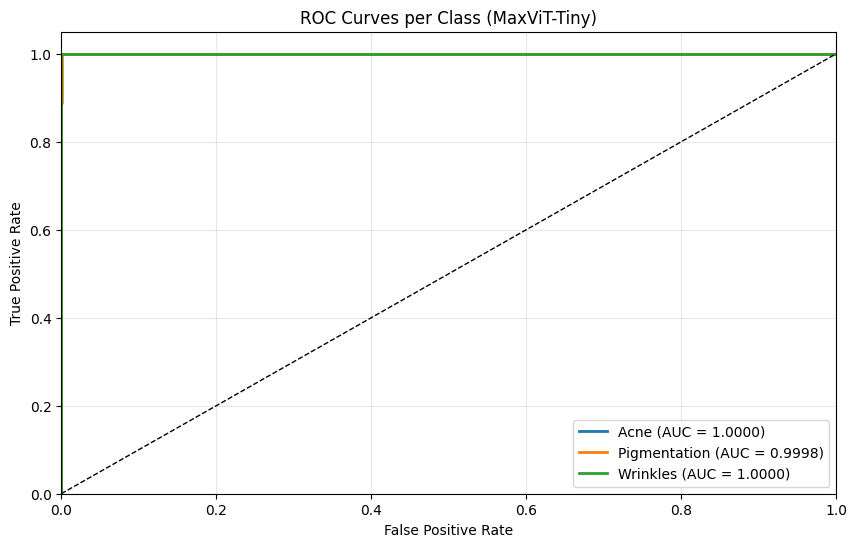

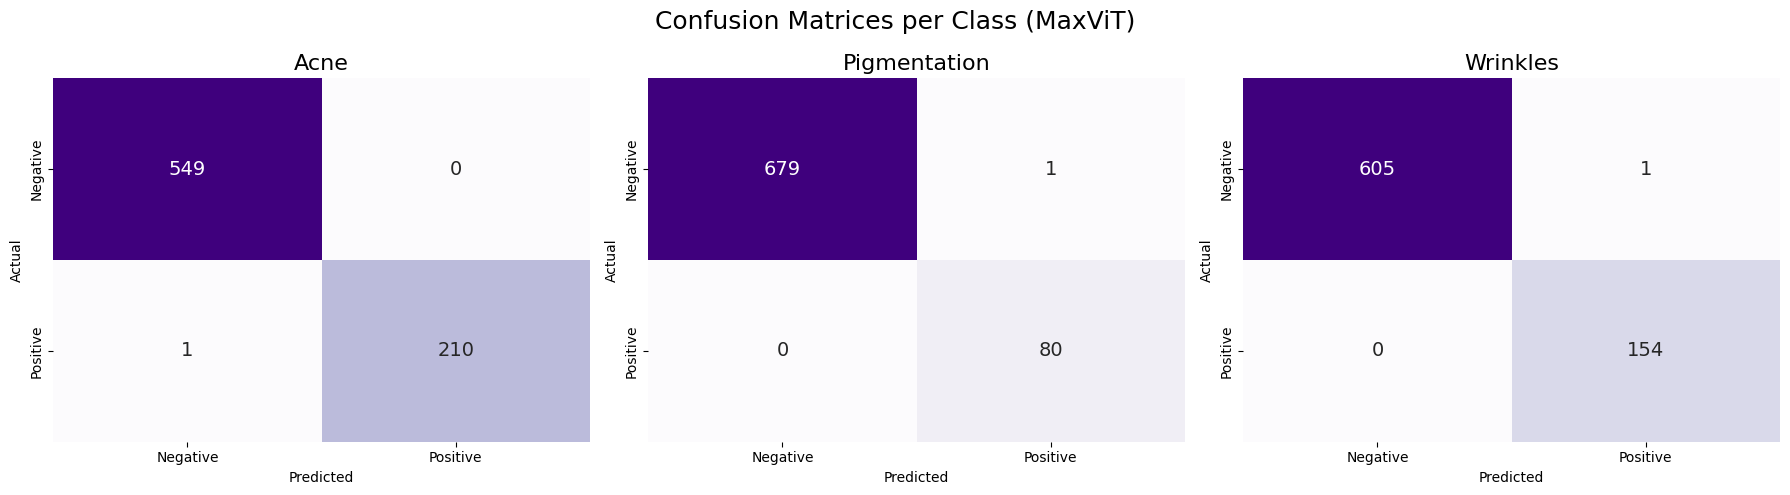

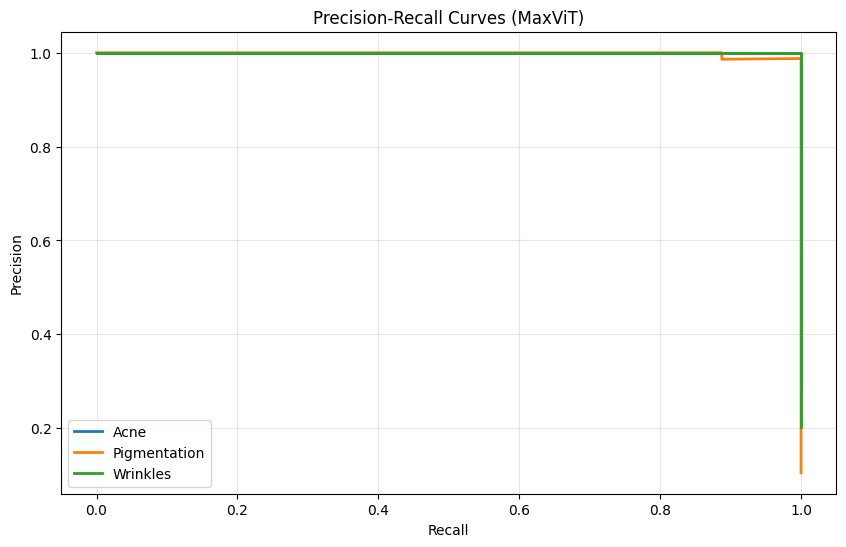


🏆 MaxViT FINAL RESULTS REPORT
🔹 ACNE:
   AUC:       1.0000
   Accuracy:  0.9987
   Precision: 1.0000
   Recall:    0.9953
--------------------
🔹 PIGMENTATION:
   AUC:       0.9998
   Accuracy:  0.9987
   Precision: 0.9877
   Recall:    1.0000
--------------------
🔹 WRINKLES:
   AUC:       1.0000
   Accuracy:  0.9987
   Precision: 0.9935
   Recall:    1.0000
--------------------

🏆 OVERALL MACRO AUC: 0.99994
✅ All plots and predictions saved to /kaggle/working/


In [10]:
# ==============================================================================
# CELL 8: MaxViT Evaluation, Plots & Ensemble Saving
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve)
import os

# Ensure Output Directory Exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

print("\n📊 Evaluating MaxViT Model on Test Set...")

# 1. Generate Predictions
print("   Generating predictions (this may take a moment)...")
y_pred_proba = final_model.predict(test_ds, verbose=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 2. Save Prediction Array (CRITICAL for Ensemble Step)
np.save(os.path.join(OUTPUT_DIR, "maxvit_preds.npy"), y_pred_proba)
np.save(os.path.join(OUTPUT_DIR, "maxvit_true_labels.npy"), y_true)
print(f"✅ Predictions saved to {OUTPUT_DIR} for ensemble step.")

# Convert to Binary (Threshold 0.5)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# --- PLOT 1: ROC CURVES (All Classes) ---
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

for i, class_name in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_true[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'{class_name.capitalize()} (AUC = {auc_score:.4f})', color=colors[i], linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1) # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class (MaxViT-Tiny)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, "maxvit_roc_curves.png"), dpi=300)
plt.show()

# --- PLOT 2: CONFUSION MATRICES (Side-by-Side) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, class_name in enumerate(CLASSES):
    cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[i], cbar=False, annot_kws={"size": 14})
    axes[i].set_title(f'{class_name.capitalize()}', fontsize=16)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticklabels(['Negative', 'Positive'])
    axes[i].set_yticklabels(['Negative', 'Positive'])

plt.suptitle('Confusion Matrices per Class (MaxViT)', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "maxvit_confusion_matrices.png"), dpi=300)
plt.show()

# --- PLOT 3: PRECISION-RECALL CURVES ---
plt.figure(figsize=(10, 6))

for i, class_name in enumerate(CLASSES):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'{class_name.capitalize()}', color=colors[i], linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (MaxViT)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, "maxvit_pr_curves.png"), dpi=300)
plt.show()

# --- TEXT REPORT ---
print("\n" + "="*40)
print("🏆 MaxViT FINAL RESULTS REPORT")
print("="*40)

for i, class_name in enumerate(CLASSES):
    auc = roc_auc_score(y_true[:, i], y_pred_proba[:, i])
    acc = accuracy_score(y_true[:, i], y_pred_binary[:, i])
    prec = precision_score(y_true[:, i], y_pred_binary[:, i], zero_division=0)
    rec = recall_score(y_true[:, i], y_pred_binary[:, i], zero_division=0)
    
    print(f"🔹 {class_name.upper()}:")
    print(f"   AUC:       {auc:.4f}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print("-" * 20)

# Overall
macro_auc = roc_auc_score(y_true, y_pred_proba, average='macro')
print(f"\n🏆 OVERALL MACRO AUC: {macro_auc:.5f}")
print(f"✅ All plots and predictions saved to {OUTPUT_DIR}")